In [13]:
import utils
import matlab.engine
import dataset
import lstm_model
import os
import reference_impl

cfg = utils.Config(
    num_rx_antennas=1,
    num_tx_antennas=32,
    num_subcarriers=80,
    train_test_split=0.8,
    data_root="../data/dataset2",
    reduce_pca_overhead=False,
    epochs=10,
    predictor_window_size = 15,
    total_bits=128,
    results_save_path="../results/deneme",
    compressor_type="kmeans",
    preprocessor_type="real_imag",
    trunc_lstm_pred=20,
    normalization_type="max",
    train_snr=-1, #no noise
    test_snr=-1, #no noise
    # duplicate_data=1,
    # data_snr=-1
)


dataset.combine_time_series_paths(
    cfg.data_root,
    list(range(32)),
    2.5e9,
    "train_set.pickle"
)
dataset.combine_time_series_paths(
    cfg.data_root,
    list(range(33,40)),
    2.62e9,
    "test_set.pickle"
)

matlab = matlab.engine.start_matlab()

Saving files to  ../data/dataset2\train_set.pickle
Number of samples (13865, 1, 32, 1, 80)
Saving files to  ../data/dataset2\test_set.pickle
Number of samples (3086, 1, 32, 1, 80)


## Train the LSTM Model

In [14]:
train_set = dataset.dataset_from_path(os.path.join(cfg.data_root, "train_set.pickle"), cfg)
test_set = dataset.dataset_from_path(os.path.join(cfg.data_root, "test_set.pickle"), cfg)

fullLSTM = lstm_model.FullLSTMModel(cfg, matlab)

This is the LSTM


In [15]:
fullLSTM.fit(train_set)

Fitting the PCA
Fitting the LSTM
Training k-means clustering...


  0%|          | 0/7 [00:00<?, ?it/s]

## Test the LSTM Model

In [16]:
# Downlink
compressed_error, X_test = fullLSTM.process(test_set)

# Uplink
ul_pred_csi = fullLSTM.decode(compressed_error, X_test)

Predicted zdl: (3056, 500)
Predicted zdl: (3056, 500)
ul_pred_error: (3056, 500)


Assessing performance...
Plotting results...


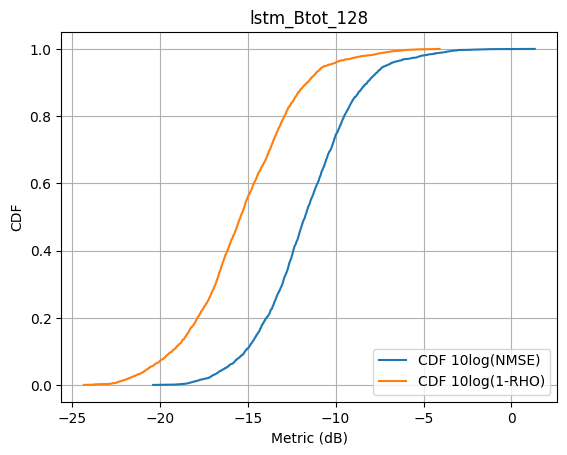

In [17]:
lstm_nmse = utils.reference_nmse_rho_test("lstm", test_set.csi_samples[cfg.predictor_window_size:], ul_pred_csi, save_path=cfg.results_save_path, btot=cfg.total_bits)

### (Optional) Time Series simulation for LSTM Model


In [18]:
initial_history = fullLSTM.get_initial_history(test_set)
compressed_error = fullLSTM.simulate_ue(test_set, initial_history)
# BS
ul_pred_csi = fullLSTM.simulate_bs(compressed_error, initial_history)

  0%|          | 0/3056 [00:00<?, ?it/s]

  0%|          | 0/3056 [00:00<?, ?it/s]

Assessing performance...
Plotting results...


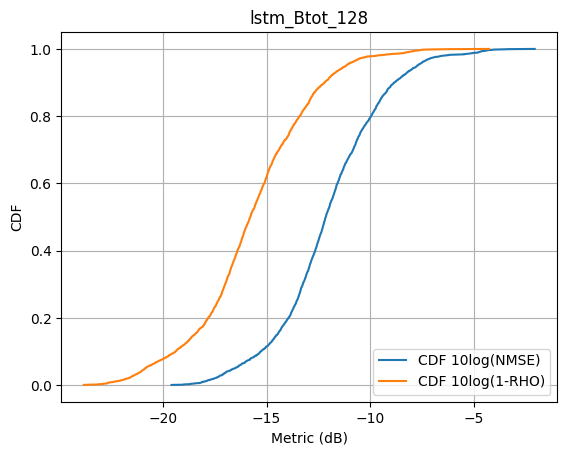

In [19]:
lstm_nmse = utils.reference_nmse_rho_test("lstm", test_set.csi_samples[cfg.predictor_window_size:], ul_pred_csi, save_path=cfg.results_save_path, btot=cfg.total_bits)

## Train Reference Model

In [20]:
train_set = dataset.dataset_from_path(os.path.join(cfg.data_root, "train_set.pickle"), cfg)
test_set = dataset.dataset_from_path(os.path.join(cfg.data_root, "test_set.pickle"), cfg)
refModel = reference_impl.FullReferenceModel(cfg, matlab)

In [21]:
refModel.fit(train_set)

Training k-means clustering...


  0%|          | 0/7 [00:00<?, ?it/s]

## Test Reference Model

Assessing performance...
Plotting results...


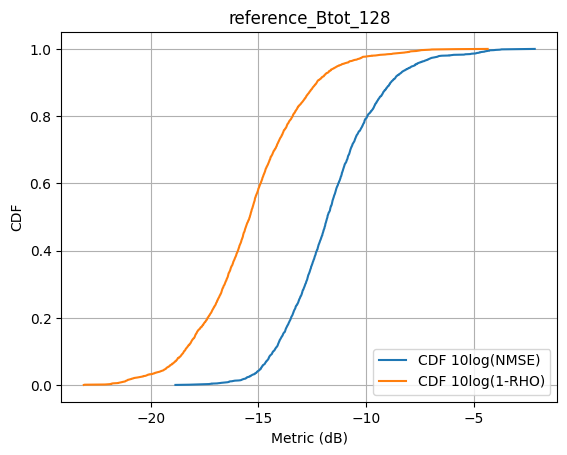

In [22]:
# Downlink
prediction_error, zdl_windows = refModel.process(test_set)

# Uplink
ul_pred_csi = refModel.decode(prediction_error, zdl_windows)
ref_nmse = utils.reference_nmse_rho_test("reference", test_set.csi_samples, ul_pred_csi, save_path=cfg.results_save_path,
                              btot=cfg.total_bits)

## Compare Results

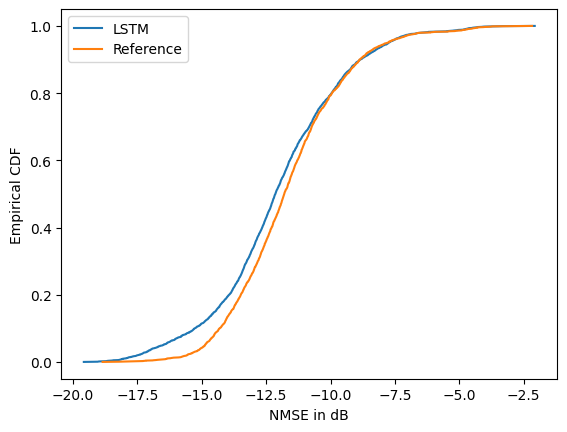

In [23]:
import numpy as np
import matplotlib.pyplot as plt

nmses = []
leg = []
nmses.append(lstm_nmse)
leg.append("LSTM")
nmses.append(ref_nmse)
leg.append("Reference")

for i in range(len(nmses)):
    nmse = nmses[i]
    cdf_nmse = np.sort(10 * np.log10(nmse))
    # cdf_rho = np.sort(10 * np.log10(1 - rho))

    probabilities = np.arange(1, len(cdf_nmse) + 1) / len(cdf_nmse)

    plt.plot(cdf_nmse, probabilities, label='CDF 10log(NMSE)')

    plt.xlabel('NMSE in dB')
    plt.ylabel('Empirical CDF')

plt.legend(leg)


The above figure shows a comparison of the NMSEs between the estimated and actual CSIs for the reference and LSTM models.
Lower NMSE is better, and for a large proportion of the data, the LSTM model outperforms the Reference.